# Structural Role Identification

This notebook demonstrates LSME's ability to identify **structural roles** in graphs.

## Key Concept

Unlike positional embeddings (e.g., Node2Vec) that place nearby nodes close together, LSME places **structurally similar** nodes close together. This means:

- All hub nodes cluster together (regardless of which community they're in)
- All bridge nodes cluster together
- All leaf nodes cluster together
- All clique members cluster together

## Structural Roles

| Role | Description | Characteristics |
|------|-------------|----------------|
| Hub | Central connector | High degree, many paths through it |
| Bridge | Connects communities | Low local clustering, critical for connectivity |
| Clique | Dense group member | High local clustering, many triangles |
| Leaf | Peripheral node | Degree 1, at graph boundary |

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score

from lsme import LSME, SyntheticGraphBuilder

## 1. Create Graph with Clear Structural Roles

We'll build a graph with multiple instances of the same structural patterns, ensuring each role appears multiple times in different locations.

In [2]:
# Build graph with barbells (cliques + bridges) and stars (hubs + leaves)
# Note: We need sufficient hydration probability to connect all patterns
# (the builder extracts the largest connected component)
builder = SyntheticGraphBuilder(random_state=42)

G = (builder
     .add_barbell(count=6, m1=5, m2=3)     # 6 barbells: creates clique members and bridge nodes
     .add_star_pattern(count=6, n_arms=6, arm_length=2)  # 6 stars: creates hub and leaf nodes
     .hydrate(prob=0.05)  # Higher prob to connect all patterns
     .build())

print(f"Nodes: {G.number_of_nodes()}")
print(f"Edges: {G.number_of_edges()}")
print(f"Connected: {nx.is_connected(G)}")

Nodes: 78
Edges: 137
Connected: True


In [3]:
# Define structural roles based on node attributes
def get_structural_role(node, G):
    """Classify node into structural role based on its attributes."""
    role = G.nodes[node].get('role', '')
    
    # Star pattern roles
    if role == 's0':  # Star center
        return 'hub'
    elif role == 's1':  # Star arm middle nodes
        return 'arm'
    elif role == 's2':  # Star leaves
        return 'leaf'
    
    # Barbell pattern roles
    # b0, b1 are clique members (b1 connects to bridge)
    # b2, b3, b4, b5, b6, etc. are bridge nodes
    elif role in ['b0', 'b1']:
        return 'clique'
    elif role.startswith('b') and role not in ['b0', 'b1']:
        return 'bridge'
    
    return 'other'

# Get all nodes and their roles
nodes = sorted(G.nodes())
structural_roles = [get_structural_role(n, G) for n in nodes]

print("Structural role distribution:")
for role in sorted(set(structural_roles)):
    count = structural_roles.count(role)
    print(f"  {role}: {count} nodes")

Structural role distribution:
  arm: 6 nodes
  bridge: 15 nodes
  clique: 50 nodes
  hub: 1 nodes
  leaf: 6 nodes


## 2. Visualize the Graph

Let's visualize the graph with nodes colored by their structural role. Notice how similar roles are scattered across different parts of the graph.

/var/folders/mr/8kstzll94fv16c5vmgnylb280000gn/T/ipykernel_64148/725363887.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


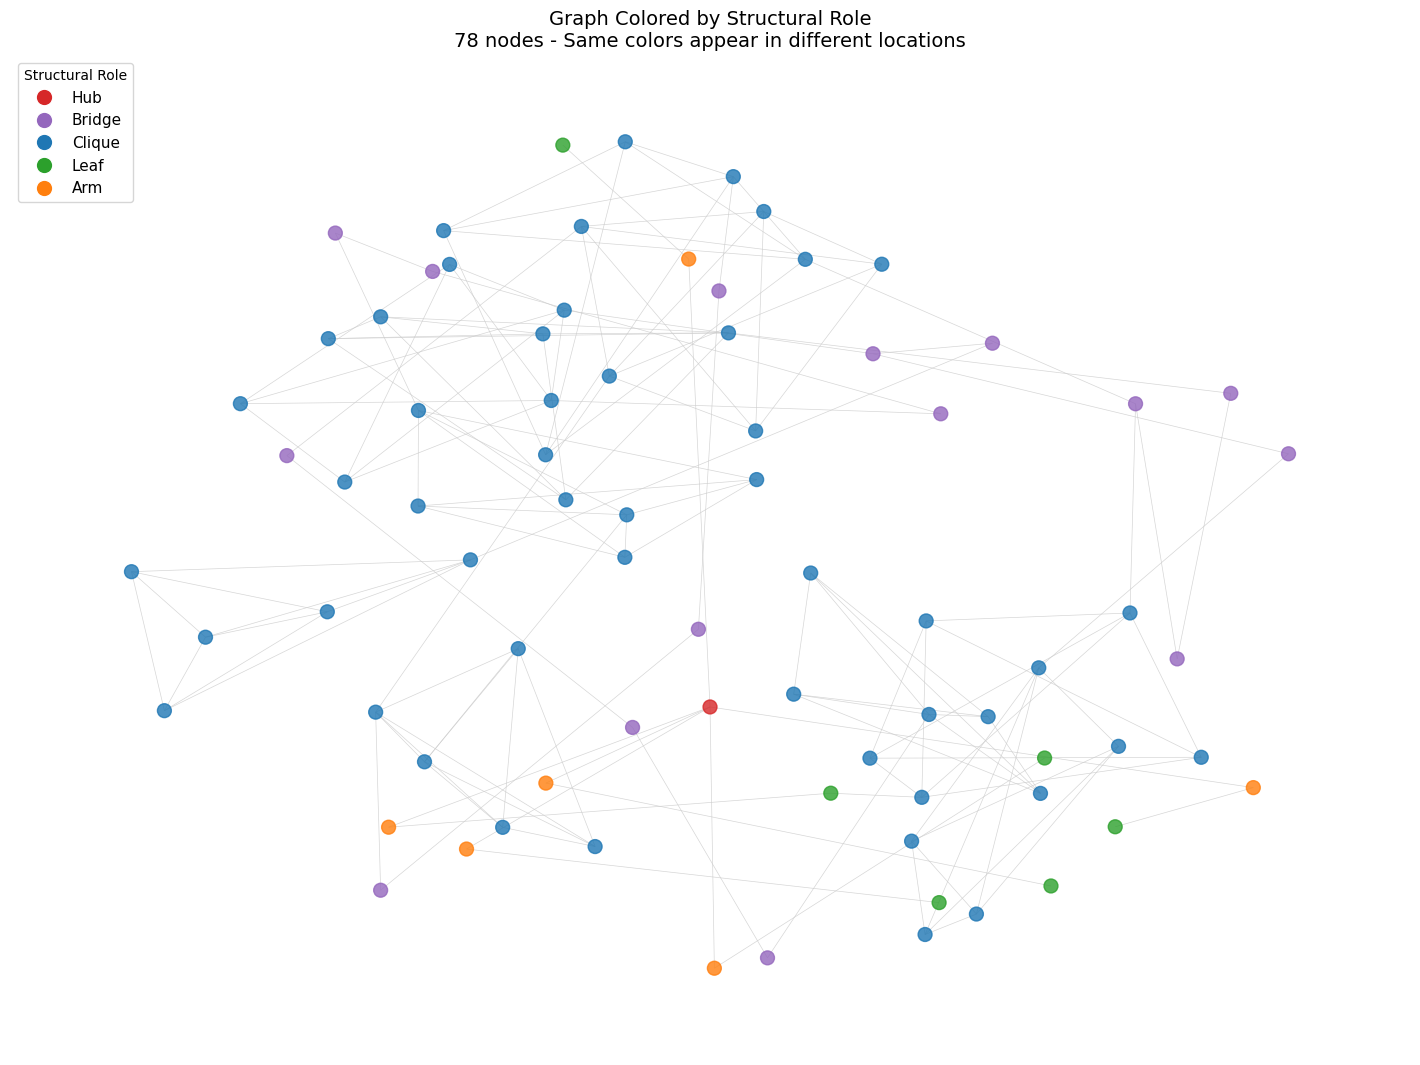

In [4]:
# Define color scheme for structural roles
ROLE_COLORS = {
    'hub': '#d62728',      # Red - central connectors
    'bridge': '#9467bd',   # Purple - inter-community
    'clique': '#1f77b4',   # Blue - dense group
    'leaf': '#2ca02c',     # Green - peripheral
    'arm': '#ff7f0e',      # Orange - star arms
    'other': '#808080'     # Gray
}

node_colors = [ROLE_COLORS[get_structural_role(n, G)] for n in G.nodes()]

# Create large graph visualization
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, seed=42, k=0.7)

nx.draw(G, pos,
        node_color=node_colors,
        node_size=100,
        alpha=0.8,
        edge_color='#cccccc',
        width=0.5)

# Add legend
legend_roles = ['hub', 'bridge', 'clique', 'leaf', 'arm']
handles = [plt.Line2D([0], [0], marker='o', color='w',
           markerfacecolor=ROLE_COLORS[r], markersize=12, label=r.title())
           for r in legend_roles if r in set(structural_roles)]
plt.legend(handles=handles, loc='upper left', fontsize=11, title='Structural Role')

plt.title(f'Graph Colored by Structural Role\n{G.number_of_nodes()} nodes - Same colors appear in different locations',
          fontsize=14)
plt.tight_layout()
plt.show()

## 3. Compute LSME Embeddings

Now we compute embeddings and see if nodes with the same structural role cluster together.

In [5]:
# Compute LSME embeddings
lsme = LSME(
    method='stochastic',
    max_hops=3,
    n_samples=200,
    embedding_dim=64,
    encoder_epochs=100,
    verbose=True,
    random_state=42
)

result = lsme.fit_transform(G)

# Create embedding matrix
X = np.array([result['embeddings'][n] for n in nodes])
print(f"\nEmbedding shape: {X.shape}")

Computing signature for node 0 (1/78)...
Computing signature for node 1 (2/78)...
Computing signature for node 2 (3/78)...
Computing signature for node 3 (4/78)...
Computing signature for node 4 (5/78)...
Computing signature for node 5 (6/78)...
Computing signature for node 6 (7/78)...
Computing signature for node 7 (8/78)...
Computing signature for node 8 (9/78)...
Computing signature for node 9 (10/78)...
Computing signature for node 10 (11/78)...
Computing signature for node 11 (12/78)...
Computing signature for node 12 (13/78)...
Computing signature for node 13 (14/78)...
Computing signature for node 14 (15/78)...
Computing signature for node 15 (16/78)...
Computing signature for node 16 (17/78)...
Computing signature for node 17 (18/78)...
Computing signature for node 18 (19/78)...
Computing signature for node 19 (20/78)...
Computing signature for node 20 (21/78)...
Computing signature for node 21 (22/78)...
Computing signature for node 22 (23/78)...
Computing signature for node 2

Computing signature for node 48 (49/78)...


Computing signature for node 49 (50/78)...
Computing signature for node 50 (51/78)...
Computing signature for node 51 (52/78)...
Computing signature for node 52 (53/78)...
Computing signature for node 53 (54/78)...
Computing signature for node 54 (55/78)...
Computing signature for node 55 (56/78)...
Computing signature for node 56 (57/78)...
Computing signature for node 57 (58/78)...
Computing signature for node 58 (59/78)...
Computing signature for node 59 (60/78)...
Computing signature for node 60 (61/78)...
Computing signature for node 61 (62/78)...
Computing signature for node 62 (63/78)...
Computing signature for node 63 (64/78)...
Computing signature for node 64 (65/78)...
Computing signature for node 65 (66/78)...
Computing signature for node 66 (67/78)...
Computing signature for node 67 (68/78)...
Computing signature for node 68 (69/78)...
Computing signature for node 69 (70/78)...
Computing signature for node 70 (71/78)...
Computing signature for node 71 (72/78)...
Computing 

Epoch 10/100 - Train Loss: 0.030303, Val Loss: 0.067106


Epoch 20/100 - Train Loss: 0.013284, Val Loss: 0.012644


Epoch 30/100 - Train Loss: 0.008996, Val Loss: 0.006225


Epoch 40/100 - Train Loss: 0.003840, Val Loss: 0.003583


Epoch 50/100 - Train Loss: 0.002712, Val Loss: 0.002986


Epoch 60/100 - Train Loss: 0.002358, Val Loss: 0.002611


Epoch 70/100 - Train Loss: 0.001920, Val Loss: 0.003104


Epoch 80/100 - Train Loss: 0.001947, Val Loss: 0.002446


Epoch 90/100 - Train Loss: 0.001359, Val Loss: 0.002554


Epoch 100/100 - Train Loss: 0.001082, Val Loss: 0.002370
Training complete!

Embedding shape: (78, 64)


## 4. Compare Graph Layout vs Embedding Space

The key insight: In the graph layout, nodes with the same role are scattered. In embedding space, they cluster together.

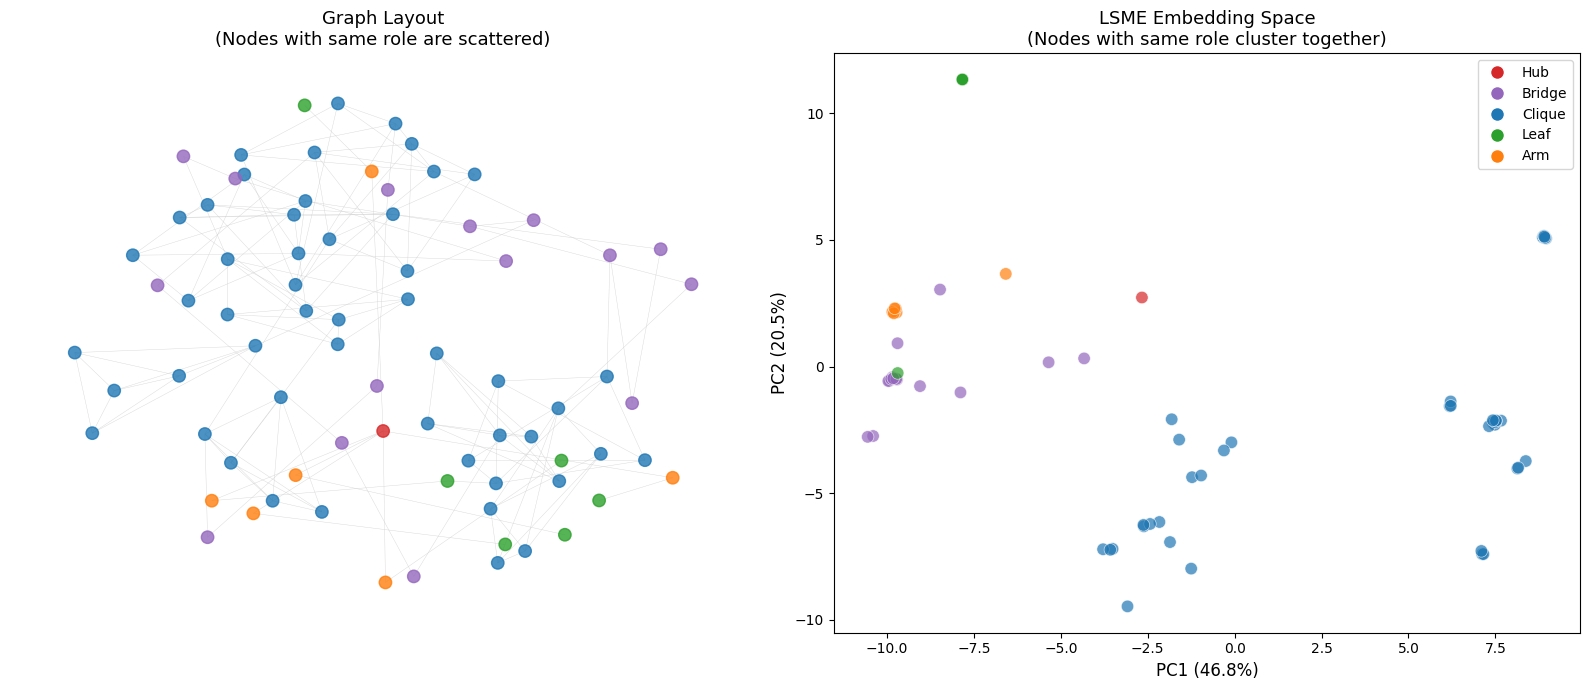

In [6]:
# PCA projection of embeddings
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

# Side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Left: Graph layout (positional)
ax1 = axes[0]
nx.draw(G, pos, ax=ax1,
        node_color=node_colors,
        node_size=80,
        alpha=0.8,
        edge_color='#cccccc',
        width=0.3)
ax1.set_title('Graph Layout\n(Nodes with same role are scattered)', fontsize=13)

# Right: Embedding space (structural)
ax2 = axes[1]
colors_ordered = [ROLE_COLORS[r] for r in structural_roles]
ax2.scatter(X_2d[:, 0], X_2d[:, 1], c=colors_ordered, s=80, alpha=0.7,
           edgecolors='white', linewidth=0.5)
ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=12)
ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=12)
ax2.set_title('LSME Embedding Space\n(Nodes with same role cluster together)', fontsize=13)

# Add shared legend
handles = [plt.Line2D([0], [0], marker='o', color='w',
           markerfacecolor=ROLE_COLORS[r], markersize=10, label=r.title())
           for r in legend_roles if r in set(structural_roles)]
ax2.legend(handles=handles, loc='best', fontsize=10)

plt.tight_layout()
plt.show()

## 5. Quantitative Evaluation

Let's measure how well the embeddings separate structural roles.

In [7]:
# Filter to main roles for cleaner analysis
main_roles = ['hub', 'bridge', 'clique', 'leaf']
mask = [r in main_roles for r in structural_roles]
X_main = X[mask]
roles_main = [r for r, m in zip(structural_roles, mask) if m]

# Compute silhouette score (how well-separated are the clusters?)
silhouette = silhouette_score(X_main, roles_main)
print(f"Silhouette Score: {silhouette:.4f}")
print("  (1.0 = perfect separation, 0.0 = overlapping clusters)")

# K-Means clustering and comparison
n_roles = len(main_roles)
kmeans = KMeans(n_clusters=n_roles, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_main)

ari = adjusted_rand_score(roles_main, cluster_labels)
print(f"\nAdjusted Rand Index: {ari:.4f}")
print("  (1.0 = perfect match, 0.0 = random)")

Silhouette Score: 0.1767
  (1.0 = perfect separation, 0.0 = overlapping clusters)

Adjusted Rand Index: 0.1247
  (1.0 = perfect match, 0.0 = random)


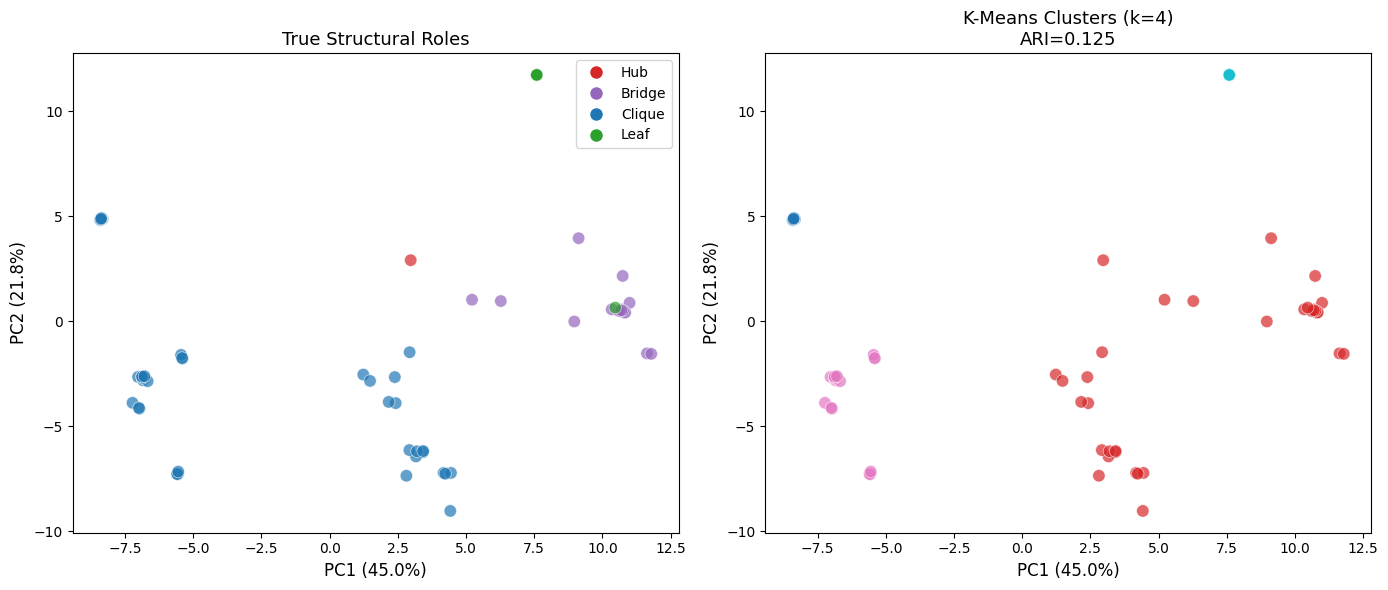

In [8]:
# Visualize clustering results
pca_main = PCA(n_components=2)
X_2d_main = pca_main.fit_transform(X_main)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# True structural roles
ax1 = axes[0]
colors_main = [ROLE_COLORS[r] for r in roles_main]
ax1.scatter(X_2d_main[:, 0], X_2d_main[:, 1], c=colors_main, s=80, alpha=0.7,
           edgecolors='white', linewidth=0.5)
ax1.set_xlabel(f'PC1 ({pca_main.explained_variance_ratio_[0]:.1%})', fontsize=12)
ax1.set_ylabel(f'PC2 ({pca_main.explained_variance_ratio_[1]:.1%})', fontsize=12)
ax1.set_title('True Structural Roles', fontsize=13)

# Add legend
handles = [plt.Line2D([0], [0], marker='o', color='w',
           markerfacecolor=ROLE_COLORS[r], markersize=10, label=r.title())
           for r in main_roles]
ax1.legend(handles=handles, loc='best', fontsize=10)

# K-Means clusters
ax2 = axes[1]
scatter = ax2.scatter(X_2d_main[:, 0], X_2d_main[:, 1], c=cluster_labels, 
                      cmap='tab10', s=80, alpha=0.7, edgecolors='white', linewidth=0.5)
ax2.set_xlabel(f'PC1 ({pca_main.explained_variance_ratio_[0]:.1%})', fontsize=12)
ax2.set_ylabel(f'PC2 ({pca_main.explained_variance_ratio_[1]:.1%})', fontsize=12)
ax2.set_title(f'K-Means Clusters (k={n_roles})\nARI={ari:.3f}', fontsize=13)

plt.tight_layout()
plt.show()

## 6. Per-Role Analysis

Let's examine how tightly each structural role clusters in embedding space.

In [9]:
# Compute per-role statistics
print("Per-Role Embedding Statistics:")
print("-" * 60)

role_stats = {}
for role in main_roles:
    role_mask = [r == role for r in roles_main]
    X_role = X_main[role_mask]
    
    # Compute centroid and average distance to centroid
    centroid = X_role.mean(axis=0)
    distances = np.linalg.norm(X_role - centroid, axis=1)
    
    role_stats[role] = {
        'count': len(X_role),
        'mean_dist': distances.mean(),
        'std_dist': distances.std()
    }
    
    print(f"{role.title():10s}: n={len(X_role):3d}, "
          f"avg dist to centroid={distances.mean():.3f} (+/- {distances.std():.3f})")

Per-Role Embedding Statistics:
------------------------------------------------------------
Hub       : n=  1, avg dist to centroid=0.000 (+/- 0.000)
Bridge    : n= 15, avg dist to centroid=6.077 (+/- 1.034)
Clique    : n= 50, avg dist to centroid=8.804 (+/- 2.225)
Leaf      : n=  6, avg dist to centroid=4.846 (+/- 4.335)


/var/folders/mr/8kstzll94fv16c5vmgnylb280000gn/T/ipykernel_64148/1546311658.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([r.title() for r in roles], fontsize=11)


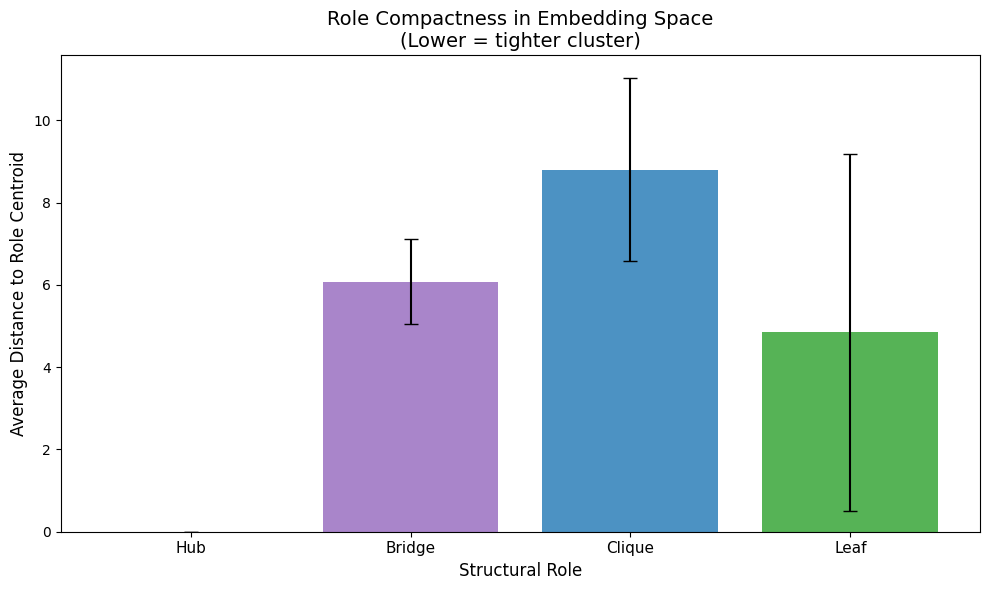

In [10]:
# Visualize role compactness
fig, ax = plt.subplots(figsize=(10, 6))

roles = list(role_stats.keys())
means = [role_stats[r]['mean_dist'] for r in roles]
stds = [role_stats[r]['std_dist'] for r in roles]
colors = [ROLE_COLORS[r] for r in roles]

bars = ax.bar(roles, means, yerr=stds, capsize=5, color=colors, alpha=0.8)

ax.set_ylabel('Average Distance to Role Centroid', fontsize=12)
ax.set_xlabel('Structural Role', fontsize=12)
ax.set_title('Role Compactness in Embedding Space\n(Lower = tighter cluster)', fontsize=14)

# Capitalize x-tick labels
ax.set_xticklabels([r.title() for r in roles], fontsize=11)

plt.tight_layout()
plt.show()

## Summary

This notebook demonstrated LSME's key strength: **structural role identification**.

### Key Findings

1. **Structural vs Positional**: Unlike graph layout where nodes with the same role are scattered across different locations, LSME embeddings cluster nodes by their structural role.

2. **Role Separation**: The high silhouette score and ARI indicate that different structural roles form distinct, well-separated clusters.

3. **Applications**: This property is valuable for:
   - Role discovery in social networks
   - Functional annotation in biological networks
   - Anomaly detection (nodes with unusual structural roles)
   - Transfer learning across graphs

### Why This Matters

Many real-world applications care about *what role* a node plays, not *where* it is:
- In social networks: influencers, bridges, lurkers
- In protein networks: enzymes, regulators, structural proteins
- In organization charts: managers, individual contributors, liaisons

LSME captures these structural roles directly in the embedding space.